In [2]:
# 1. Need to Get the Airport Location NY_Airport_Data [Done]

import csv
import pandas as pd
from lat_lon_parser import parse
import folium as fd
from IPython.display import HTML, display

airport_df = pd.read_csv(r'Aircraft_Landing_Facilities.csv')
airport_df = airport_df[['ref_point_lat','ref_point_lon','objectid','fac_type','loc_id','region_code','state_name','county','fac_name']]
airport_df = airport_df[airport_df.state_name=='WASHINGTON']
airport_df = airport_df[airport_df.fac_type=='AIRPORT']

airport_df_temp = airport_df.reset_index(drop=True)


def calculate_lat(row):
    val = parse(row['ref_point_lat'])
    return val
def calculate_lon(row):
    val = parse(row['ref_point_lon'])
    return val

airport_df['lat'] = (airport_df.apply(calculate_lat, axis=1)).round(2)
airport_df['lon'] = (airport_df.apply(calculate_lon, axis=1)).round(3)
airport_df = airport_df.reset_index(drop=True)
# v = parse("41-13-51.7000N")



/Users/meghasinghrajpoot/opt/anaconda3/envs/dataBaseFinal/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (51,52,53) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import os


for i in range(1,92):

    netcdf_file_name = './data/windData/' + str(i) + '.nc4'
    csv_file_out = './data/windCSV/' + str(i) + '.csv'

    ds = xr.open_dataset(netcdf_file_name)
    df = ds.to_dataframe()
    print(df.describe())
    df.to_csv(csv_file_out)

    windspeed_df = pd.read_csv(csv_file_out)
    windspeed_df = pd.DataFrame(windspeed_df)

    windspeed_df = windspeed_df[['lat','lon','U50M','V50M','time']]
    windspeed_df['lat'] = windspeed_df['lat'].round(2)
    windspeed_df['lon'] = windspeed_df['lon'].round(2)
    windspeed_df['date'] = pd.to_datetime(windspeed_df['time']).dt.date

    csv_file_out_processed = './data/windCSV/' + str(i) + "_final.csv"
    windspeed_df.to_csv(csv_file_out_processed)
    os.remove(csv_file_out)


    # Compute the wind speed for the NewYork State on daily basis.....

    windspeed_df = pd.read_csv(csv_file_out_processed)
    windspeed_df = pd.DataFrame(windspeed_df)

    lon = windspeed_df['lon']
    lat = windspeed_df['lat']
    date = windspeed_df['date']

    # 2-meter eastward wind m/s
    U50M = windspeed_df['U50M']
    # 2-meter northward wind m/s
    V50M = windspeed_df['V50M']

    # Replace _FillValues with NaNs:df.replace(r'^\s*$', np.nan, regex=True)
    U2M_nans = U50M[:].replace(r'^\s*$', np.nan, regex=True)
    V2M_nans = V50M[:].replace(r'^\s*$', np.nan, regex=True)

    # Calculate wind speed:
    ws = np.sqrt(U2M_nans**2+V2M_nans**2)
    list_s = [lat, lon, date]

    new_df = pd.concat(list_s, axis=1)
    new_df['avg_windspeed'] = ws
    print(new_df.columns)
    new_df = pd.DataFrame(new_df.groupby(['lat','lon']).mean()).reset_index()
    new_df['date'] = date
    new_df.to_csv(csv_file_out_processed)



/Users/meghasinghrajpoot/opt/anaconda3/envs/dataBaseFinal/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/Users/meghasinghrajpoot/opt/anaconda3/envs/dataBaseFinal/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


              V50M         Q500         U50M         U500
count  4488.000000  4488.000000  4488.000000  4488.000000
mean     -1.741778     0.000301     2.502198    -0.131713
std       2.283449     0.000380     1.871535     6.657388
min      -9.534804     0.000022    -3.604071   -17.564075
25%      -2.913165     0.000091     1.255760    -4.366056
50%      -1.472345     0.000164     2.436894    -0.014014
75%      -0.189131     0.000272     3.737019     3.741014
max       4.153464     0.001926     8.923653    27.589952
Index(['lat', 'lon', 'date', 'avg_windspeed'], dtype='object')
              V50M         Q500         U50M         U500
count  4488.000000  4488.000000  4488.000000  4488.000000
mean      1.399734     0.001179     4.229885    14.574148
std       2.215552     0.000316     2.248814     9.796882
min      -8.418101     0.000030    -3.854656   -13.620913
25%      -0.063772     0.000985     2.843875     7.974557
50%       1.528249     0.001200     4.287557    14.716185
75%      

In [4]:
def generate_blocks(csv_file_out):
    ws_df = pd.read_csv(csv_file_out)
    ws_df = pd.DataFrame(ws_df)

    _blocks = {
        'lower_left_lat': [],
        'lower_left_lon': [],
        'upper_right_lat': [],
        'upper_right_lon': [],
        'avg_speed': [],
        'date': [],

    }
    # retrieve lat lon list
    lat_list = sorted(set(ws_df['lat'].tolist()))
    lon_list = sorted(set(ws_df['lon'].tolist()))
    date_list = (set(ws_df['date'].tolist()))
    # for loop to generate all blocks
    # todo change 'avg windspeed' to wind speed
    speed = 0
    for x in range(len(lat_list) - 1):
        for y in range(len(lon_list) - 1):
            speed += ws_df[
                (ws_df['lat'] == lat_list[x]) &
                (ws_df['lon'] == lon_list[y])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x + 1]) &
                (ws_df['lon'] == lon_list[y])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x]) &
                (ws_df['lon'] == lon_list[y + 1])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x + 1]) &
                (ws_df['lon'] == lon_list[y + 1])]['avg_windspeed'].tolist()[0]

            speed = speed / 4
            _blocks['lower_left_lat'].append(lat_list[x])
            _blocks['upper_right_lat'].append(lat_list[x + 1])
            _blocks['lower_left_lon'].append(lon_list[y])
            _blocks['upper_right_lon'].append(lon_list[y + 1])
            _blocks['avg_speed'].append(speed)
            _blocks['date'].append(ws_df.loc[x,'date'])
            speed = 0
        
        
    blocks = pd.DataFrame(_blocks)
    blocks.to_csv(csv_file_out)


for i in range(1,92):
    csv_file_out = './data/windCSV/' + str(i) + '_final.csv'
    blocks = generate_blocks(csv_file_out)

In [5]:
airport_df = airport_df.sort_values('lat')

locations = airport_df[['lat','lon']]
wind_locations = new_df[['lat','lon']]
locations_list = locations.values.tolist()
wind_list = wind_locations.values.tolist()

map = fd.Map(location=[43, -75], zoom_start=12)

for point in range(0, len(locations_list)):
    # print(locations_list[point], point)
    fd.Marker(locations_list[point], popup=airport_df['fac_name'][point]).add_to(map)


for point in range(0, len(wind_list)):
    # print(wind_list[point], point)
    fd.Marker(wind_list[point], popup=new_df['avg_windspeed'][point], icon=fd.Icon(color='red')).add_to(map)

map.save('map.html')



In [6]:
# 3. Need to get the precipitation data and calulate the avg [Need to collect]
airport_df

,ref_point_lat,ref_point_lon,objectid,fac_type,loc_id,region_code,state_name,county,fac_name,lat,lon
330,45-33-44.4300N,122-15-21.9200W,18879,AIRPORT,WA63,ANM,WASHINGTON,CLARK,PLEASANT FARM,45.56,-122.256
272,45-36-30.0000N,122-11-49.0000W,18801,AIRPORT,4WA1,ANM,WASHINGTON,SKAMANIA,BROWN'S CAPE HORN,45.61,-122.197
315,45-37-13.6290N,122-39-23.3580W,18857,AIRPORT,VUO,ANM,WASHINGTON,CLARK,PEARSON FIELD,45.62,-122.656
329,45-37-40.4220N,122-11-04.3180W,18878,AIRPORT,WA78,ANM,WASHINGTON,SKAMANIA,SKY RIVER RANCH,45.63,-122.185
37,45-37-40.1860N,122-24-15.5210W,18438,AIRPORT,1W1,ANM,WASHINGTON,CLARK,GROVE FIELD,45.63,-122.404
...,...,...,...,...,...,...,...,...,...,...,...
186,48-56-00.1700N,117-44-59.3100W,18655,AIRPORT,1WN0,ANM,WASHINGTON,STEVENS,SCHMIDT RANCH,48.93,-117.750
163,48-57-21.2260N,122-27-29.2260W,18619,AIRPORT,38W,ANM,WASHINGTON,WHATCOM,LYNDEN MUNICIPAL AIRPORT JANSEN FIELD,48.96,-122.458
206,48-57-32.3000N,119-24-43.1000W,18682,AIRPORT,0S7,ANM,WASHINGTON,OKANOGAN,DOROTHY SCOTT,48.96,-119.412
218,48-58-37.7000N,123-04-45.2000W,18697,AIRPORT,1RL,ANM,WASHINGTON,WHATCOM,POINT ROBERTS AIRPARK,48.98,-123.079


In [7]:
# Merge the data sets [Issues encountered]
def calculate_airport_avg_windspeed(airport_df, blocks):

    for row_id, row in airport_df.iterrows():
        lat_val = row.lat
        lon_val = row.lon
        filter1_a = lat_val >= blocks['lower_left_lat']
        filter1_b = lat_val <= blocks['upper_right_lat']
        filter2_a = lon_val >= blocks['lower_left_lon']
        filter2_b = lon_val <= blocks['upper_right_lon']
        calc_time = blocks[(filter1_a) & (filter1_b) & (filter2_a) & (filter2_b)].date.tolist()[0]
        calc_speed_temp = round(blocks[(filter1_a) & (filter1_b) & (filter2_a) & (filter2_b)].avg_speed.tolist()[0], 3)
        (airport_df.at[row_id, calc_time]) = calc_speed_temp
   
    return airport_df



airport_df_temp = airport_df.copy()
for i in range(1,92):
    csv_file_out = './data/windCSV/' + str(i) + '_final.csv'
    blocks_ = pd.read_csv(csv_file_out)
    blocks_ = pd.DataFrame(blocks_)
    airport_df_temp = calculate_airport_avg_windspeed(airport_df_temp, blocks_)

final_dataset_with_speed_and_airport = airport_df_temp

final_dataset_with_speed_and_airport = final_dataset_with_speed_and_airport.reset_index(drop=True)

print(final_dataset_with_speed_and_airport)


      ref_point_lat    ref_point_lon  objectid fac_type loc_id region_code  \
0    45-33-44.4300N  122-15-21.9200W     18879  AIRPORT   WA63         ANM   
1    45-36-30.0000N  122-11-49.0000W     18801  AIRPORT   4WA1         ANM   
2    45-37-13.6290N  122-39-23.3580W     18857  AIRPORT    VUO         ANM   
3    45-37-40.4220N  122-11-04.3180W     18878  AIRPORT   WA78         ANM   
4    45-37-40.1860N  122-24-15.5210W     18438  AIRPORT    1W1         ANM   
..              ...              ...       ...      ...    ...         ...   
351  48-56-00.1700N  117-44-59.3100W     18655  AIRPORT   1WN0         ANM   
352  48-57-21.2260N  122-27-29.2260W     18619  AIRPORT    38W         ANM   
353  48-57-32.3000N  119-24-43.1000W     18682  AIRPORT    0S7         ANM   
354  48-58-37.7000N  123-04-45.2000W     18697  AIRPORT    1RL         ANM   
355  48-59-54.1660N  118-13-21.3550W     18607  AIRPORT    69S         ANM   

     state_name    county                               fac_nam

In [8]:
# final_dataset_with_speed_and_airport = final_dataset_with_speed_and_airport.sort_values('lat')

# locations = final_dataset_with_speed_and_airport[['lat','lon']]
# wind_locations = new_df[['lat','lon']]
# locations_list = locations.values.tolist()
# wind_list = wind_locations.values.tolist()

# map = fd.Map(location=[43, -75], zoom_start=5)

# for point in range(0, len(locations_list)):
#     # print(locations_list[point], point)
#     title = str(final_dataset_with_speed_and_airport['fac_name'][point]) + "," + str(final_dataset_with_speed_and_airport['avg_calculated_windspeed'][point])
#     fd.Marker(locations_list[point], popup=title).add_to(map)

# for point in range(0, len(wind_list)):
#     # print(wind_list[point], point)
#     fd.Marker(wind_list[point], popup=new_df['avg_windspeed'][point], icon=fd.Icon(color='red')).add_to(map)

# map.save('airport_wind_map.html')

In [37]:
final_dataset_with_speed_and_airport.head()
# fd = final_dataset_with_speed_and_airport.columns[12:].dt.strftime('%Y-%m-%d')
# fd
#df = pd.DatetimeIndex(final_dataset_with_speed_and_airport.columns[12:]).month







,ref_point_lat,ref_point_lon,objectid,fac_type,loc_id,region_code,state_name,county,fac_name,lat,...,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31
0,45-33-44.4300N,122-15-21.9200W,18879,AIRPORT,WA63,ANM,WASHINGTON,CLARK,PLEASANT FARM,45.56,...,2.645,4.975,4.051,2.924,3.300,3.690,3.961,4.398,6.268,4.104
1,45-36-30.0000N,122-11-49.0000W,18801,AIRPORT,4WA1,ANM,WASHINGTON,SKAMANIA,BROWN'S CAPE HORN,45.61,...,2.645,4.975,4.051,2.924,3.300,3.690,3.961,4.398,6.268,4.104
2,45-37-13.6290N,122-39-23.3580W,18857,AIRPORT,VUO,ANM,WASHINGTON,CLARK,PEARSON FIELD,45.62,...,2.416,4.607,4.079,2.499,3.154,3.846,4.432,5.018,6.520,4.165
3,45-37-40.4220N,122-11-04.3180W,18878,AIRPORT,WA78,ANM,WASHINGTON,SKAMANIA,SKY RIVER RANCH,45.63,...,2.645,4.975,4.051,2.924,3.300,3.690,3.961,4.398,6.268,4.104
4,45-37-40.1860N,122-24-15.5210W,18438,AIRPORT,1W1,ANM,WASHINGTON,CLARK,GROVE FIELD,45.63,...,2.645,4.975,4.051,2.924,3.300,3.690,3.961,4.398,6.268,4.104


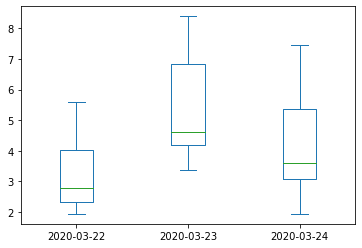

In [18]:
#Line plot
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

#final_dataset_with_speed_and_airport.head()

final_df = final_dataset_with_speed_and_airport
df = final_df[['county','2020-03-22','2020-03-23','2020-03-24']].copy()
df.head()
df.plot(kind='box')
plt.show()
# plt.xlabel(final_df['county'])
# plt.ylabel(final_df['2020-03-22'])



In [20]:
# Modelings
# 4. Peform clustering on the accounts of factors for airports.(Kmeans, KNN, )


# visual analysis
import matplotlib.pyplot as plt

visual_df = final_dataset_with_speed_and_airport.copy()
visual_df.avg_calculated_windspeed = visual_df.avg_calculated_windspeed*100
#print(visual_df)
visual_df = visual_df.drop(columns=['ref_point_lat', 'ref_point_lon', 'objectid','lat', 'lon', 'loc_id', 'region_code', 'state_name'], axis=1)
print(visual_df)
plt.figure()
visual_df.plot(x='county',y='avg_calculated_windspeed', kind='scatter')
df_albany = visual_df[visual_df.county == 'SUFFOLK']
df_albany.plot(x='fac_name',y='avg_calculated_windspeed', kind='line')

AttributeError: 'DataFrame' object has no attribute 'avg_calculated_windspeed'

Clustering Alogs: OPTICS

OPTICS clustering (where OPTICS is short for Ordering Points To Identify the Clustering Structure) is a modified version of DBSCAN described above.

We introduce a new algorithm for the purpose of cluster analysis which does not produce a clustering of a data set explicitly; but instead creates an augmented ordering of the database representing its density-based clustering structure. This cluster-ordering contains information which is equivalent to the density-based clusterings corresponding to a broad range of parameter settings.

— OPTICS: ordering points to identify the clustering structure, 1999.

The technique is described in the paper:

OPTICS: ordering points to identify the clustering structure, 1999.
It is implemented via the OPTICS class and the main configuration to tune is the “eps” and “min_samples” hyperparameters.

In [ ]:

import sklearn
print(sklearn.__version__)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler

In [ ]:
# Handling the missing values if any

airport_dataframe = visual_df.copy()
county_list = visual_df['county'].unique().tolist()

airport_dataframe['Category'] = airport_dataframe.county.astype("category").cat.codes
print(airport_dataframe.isnull().sum())

airport_dataframe_temp = airport_dataframe[['avg_calculated_windspeed','Category']].copy()
print(airport_dataframe_temp.head())


scaler = StandardScaler()
airport_dataframe_scaled = scaler.fit_transform(airport_dataframe_temp)
airport_normalized = normalize(airport_dataframe_scaled)
airport_normalized = pd.DataFrame(airport_normalized)
airport_normalized.columns = airport_dataframe_temp.columns
print(airport_normalized.head())


# Building the OPTICS Clustering model
optics_model = OPTICS(min_samples = 50, xi = 0.05, min_cluster_size = 0.05)
  
# Training the model
optics_model.fit_predict(airport_normalized)

labels_050 = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=2,
)




# Storing the cluster labels of each point
reachability = optics_model.reachability_[optics_model.ordering_]
labels = optics_model.labels_[optics_model.ordering_]
space = np.arange(len(airport_normalized))

print(len(labels))
print(reachability)


In [ ]:
# Defining the framework of the visualization
plt.figure(figsize =(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])


# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")


# Plotting the OPTICS Clustering
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for Class, colour in zip(range(0, 5), colors):
    Xk = airport_normalized[optics_model.labels_ == Class]
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3)
      
ax2.plot(airport_normalized.iloc[optics_model.labels_ == -1, 0],
        airport_normalized.iloc[optics_model.labels_ == -1, 1],
       'k+', alpha = 0.1)
ax2.set_title('OPTICS Clustering')


# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
print('# DBSCAN at 0.5')

for klass, color in zip(range(0, 6), colors):
    Xk = airport_normalized[labels_050 == klass]
    ax3.plot(Xk['avg_calculated_windspeed'], Xk['Category'], color, alpha=0.3, marker=".")

ax3.plot(airport_normalized.loc[labels_050 == -1, 'avg_calculated_windspeed'], airport_normalized.loc[labels_050 == -1, 'Category'], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = airport_normalized[labels_200 == klass]
    ax4.plot(Xk['avg_calculated_windspeed'], Xk['Category'], color, alpha=0.3)
ax4.plot(airport_normalized.loc[labels_200 == -1, 'avg_calculated_windspeed'], airport_normalized.loc[labels_200 == -1, 'Category'], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

In [ ]:

# define dataset
# optics clustering
from numpy import unique
from numpy import where 
from matplotlib import pyplot

# define the model
model = OPTICS(eps=0.8, min_samples = 50, xi = 0.05, min_cluster_size = 0.05)
# fit model and predict clusters
yhat = model.fit_predict(airport_normalized)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(airport_normalized.loc[row_ix, 'avg_calculated_windspeed'], airport_normalized.loc[row_ix, 'Category'])
# show the plot
pyplot.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
airport_dataframe2 = visual_df.copy()
airport_dataframe2['Category'] = airport_dataframe2.county.astype("category").cat.codes
print(airport_dataframe2.isnull().sum())

airport_dataframe_temp2 = airport_dataframe2[['avg_calculated_windspeed','Category']].copy()
print(airport_dataframe_temp2)

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(airport_dataframe_temp2)
    distortions.append(sum(np.min(cdist(airport_dataframe_temp2, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / airport_dataframe_temp2.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(airport_dataframe_temp2, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / airport_dataframe_temp2.shape[0]
    mapping2[k] = kmeanModel.inertia_



plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
#Initialize the class object
kmeans = KMeans(n_clusters= 4)
 
#predict the labels of clusters.
label = kmeans.fit_predict(airport_dataframe_temp2)
 
print(label)

In [ ]:

#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(airport_dataframe_temp2.loc[label == i , 'avg_calculated_windspeed'] , airport_dataframe_temp2.loc[label == i , 'Category'] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
ms = MeanShift()
ms.fit(airport_dataframe_temp2)
cluster_centers = ms.cluster_centers_
print(cluster_centers)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(airport_dataframe_temp2['avg_calculated_windspeed'], airport_dataframe_temp2['Category'], marker='o')
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', color='black', s=300, linewidth=5, zorder=10)
plt.show()